<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#빈도-분석" data-toc-modified-id="빈도-분석-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>빈도 분석</a></span><ul class="toc-item"><li><span><a href="#crosstab-(교차표)" data-toc-modified-id="crosstab-(교차표)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>crosstab (교차표)</a></span></li><li><span><a href="#freqltems()" data-toc-modified-id="freqltems()-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>freqltems()</a></span></li><li><span><a href="#Chi-Square" data-toc-modified-id="Chi-Square-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Chi Square</a></span><ul class="toc-item"><li><span><a href="#데이터" data-toc-modified-id="데이터-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>데이터</a></span></li></ul></li></ul></li></ul></div>

In [1]:
# SparkSession 생성
import pyspark
import os

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

## 빈도 분석
명목변수 : 이름이 붙어진 변수

In [2]:
names = ["kim","lee","park","lim"]
items = ["espresso","latte","americano","affocato","long black","macciato"]

In [3]:
coffeeDf = spark.createDataFrame([(names[i%4], items[i%6]) for i in range(500)],\
                           ["name","coffee"])

In [4]:
coffeeDf.describe().show()

+-------+----+--------+
|summary|name|  coffee|
+-------+----+--------+
|  count| 500|     500|
|   mean|null|    null|
| stddev|null|    null|
|    min| kim|affocato|
|    max|park|macciato|
+-------+----+--------+



In [5]:
coffeeDf.toPandas().describe()

,name,coffee
count,500,500
unique,4,6
top,kim,espresso
freq,125,84


### crosstab (교차표)

In [6]:
coffeeDf.groupBy('name').pivot('coffee').count().show()

+----+--------+---------+--------+-----+----------+--------+
|name|affocato|americano|espresso|latte|long black|macciato|
+----+--------+---------+--------+-----+----------+--------+
|park|    null|       42|      42| null|        41|    null|
| lim|      42|     null|    null|   42|      null|      41|
| kim|    null|       41|      42| null|        42|    null|
| lee|      41|     null|    null|   42|      null|      42|
+----+--------+---------+--------+-----+----------+--------+



null값이 0으로

In [7]:
coffeeDf.stat.crosstab("name", "coffee").show()

+-----------+--------+---------+--------+-----+----------+--------+
|name_coffee|affocato|americano|espresso|latte|long black|macciato|
+-----------+--------+---------+--------+-----+----------+--------+
|        lim|      42|        0|       0|   42|         0|      41|
|        lee|      41|        0|       0|   42|         0|      42|
|       park|       0|       42|      42|    0|        41|       0|
|        kim|       0|       41|      42|    0|        42|       0|
+-----------+--------+---------+--------+-----+----------+--------+



### freqltems()
임계치 이하의 최빈값

In [8]:
freq = coffeeDf.stat.freqItems(["name","coffee"], 0.5)
freq.show()

+--------------+-----------------+
|name_freqItems| coffee_freqItems|
+--------------+-----------------+
|   [lim, park]|[latte, espresso]|
+--------------+-----------------+



### Chi Square
빈도 분석
- features : 속성
- label : 맞추려는 값

#### 데이터

In [9]:
coffeeDf.printSchema()

root
 |-- name: string (nullable = true)
 |-- coffee: string (nullable = true)



In [10]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol="name", outputCol="label")
model=labelIndexer.fit(coffeeDf)
_coffeeDf=model.transform(coffeeDf)

In [11]:
_coffeeDf.printSchema()

root
 |-- name: string (nullable = true)
 |-- coffee: string (nullable = true)
 |-- label: double (nullable = false)



In [13]:
_coffeeDf.show(4)

+----+---------+-----+
|name|   coffee|label|
+----+---------+-----+
| kim| espresso|  0.0|
| lee|    latte|  1.0|
|park|americano|  3.0|
| lim| affocato|  2.0|
+----+---------+-----+
only showing top 4 rows



#### features를 벡터로 변환

In [14]:
featureIndexer = StringIndexer(inputCol="coffee", outputCol="_features")
model=featureIndexer.fit(_coffeeDf)
_coffeeDf=model.transform(_coffeeDf)

벡터라 `""`가 아니라 `[""]`

In [15]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["_features"], outputCol="features")
_coffeeDf = va.transform(_coffeeDf)

In [18]:
_coffeeDf.printSchema()
_coffeeDf.show(7)

root
 |-- name: string (nullable = true)
 |-- coffee: string (nullable = true)
 |-- label: double (nullable = false)
 |-- _features: double (nullable = false)
 |-- features: vector (nullable = true)

+----+----------+-----+---------+--------+
|name|    coffee|label|_features|features|
+----+----------+-----+---------+--------+
| kim|  espresso|  0.0|      0.0|   [0.0]|
| lee|     latte|  1.0|      1.0|   [1.0]|
|park| americano|  3.0|      3.0|   [3.0]|
| lim|  affocato|  2.0|      2.0|   [2.0]|
| kim|long black|  0.0|      4.0|   [4.0]|
| lee|  macciato|  1.0|      5.0|   [5.0]|
|park|  espresso|  3.0|      0.0|   [0.0]|
+----+----------+-----+---------+--------+
only showing top 7 rows



#### ChiSquareTest

In [19]:
from pyspark.ml.stat import ChiSquareTest
r = ChiSquareTest.test(_coffeeDf, "features", "label")

pValues가 0.05보다 작으면 귀무가설 기각 

In [20]:
r.show()

+-------+----------------+-------------------+
|pValues|degreesOfFreedom|         statistics|
+-------+----------------+-------------------+
|  [0.0]|            [15]|[500.0963855421687]|
+-------+----------------+-------------------+



In [22]:
from pyspark.ml.stat import ChiSquareTest
r = r.head()

In [23]:
print("pValues: " + str(r.pValues))
print("degreesOfFreedom: " + str(r.degreesOfFreedom))
print("statistics: " + str(r.statistics))

pValues: [0.0]
degreesOfFreedom: [15]
statistics: [500.0963855421687]


## 상관관계
- 연속변수에서 옳다
- 명목변수에는 의미 없다 -> 빈도분석이 나음

### 상관관계 방향과 강도
- `+` : 서로 같은 반향으로 영향
- `0` : 서로 영향 없음
- `-` : 서로 다른 방향으로 영향

상관 관계 : 공분산(covariance)을 표준편차의 곱으로 나눈 값

### 데이터

In [24]:
X=[10,7,12,12,9,16,12,18,8,12,14,16]
Y=[6,4,7,8,10,7,10,15,5,6,11,13]

### 그래프

#### 단순 Plot

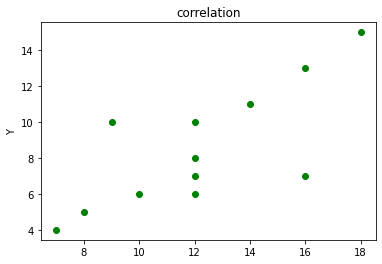

In [25]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.title('correlation')
plt.plot(X, Y, 'go')
plt.ylabel('Y')

plt.show()

#### Scatter

C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 49345 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Nunu\anaconda3\envs\py3.8\lib\site-packages\matplotlib\backends\backen

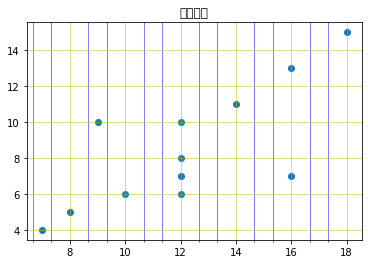

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
plt.rc('font', family='NanumMyeongjo')
ax.title.set_text('상관관계')
ax.scatter(X, Y)
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(1))
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator(3))
ax.grid(b=True, which='major', color='y', linewidth=0.5)
ax.grid(b=True, which='minor', color='b', linewidth=0.5)
#fig.show()

### numpy 공분산 계산

In [27]:
import numpy as np
xbar=np.mean(X)
ybar=np.mean(Y)

In [28]:
covxy=sum( [ (x-xbar)*(y-ybar) for x,y in zip(X,Y) ]) / (len(X)-1)
print ("simple cov=", covxy)

simple cov= 8.454545454545455


#### numpy 공분산

In [29]:
print ("np cov=\n",np.cov(X,Y))

np cov=
 [[11.42424242  8.45454545]
 [ 8.45454545 11.18181818]]


In [31]:
print (np.sum( (X-np.mean(X))**2) / (len(X)-1))
print (np.sum( (Y-np.mean(Y))**2) / (len(Y)-1))

11.424242424242424
11.181818181818182


In [32]:
print(np.var(X, ddof=1))

11.424242424242424


In [33]:
print ("npcov of X", np.cov(X)) #sum( [ (x-xbar)**2 for x in X ])/(len(X)-1)
print ("npcov of Y", np.cov(Y))

npcov of X 11.424242424242426
npcov of Y 11.181818181818182


### 상관관계

#### numpy 계산

In [34]:
import numpy as np

xbar=np.mean(X)
ybar=np.mean(Y)
sx=np.sqrt(np.var(X,ddof=1))
sy=np.sqrt(np.var(Y,ddof=1))
covxy=sum( [ (x-xbar)*(y-ybar) for x,y in zip(X,Y) ]) / (len(X)-1)

정의 관계

In [35]:
rxy=covxy/(sx*sy)
print ("corr: ",rxy)

corr:  0.7480322896763185


#### 깔끔한 상관관계 계산식

In [36]:
import math
numer = sum ( [ x*y for x,y in zip(X,Y) ] ) - len(X) * (xbar * ybar)
denom = math.sqrt( (sum( [ x*x for x in X ]) - len(X) * xbar**2) * ( sum( [ y * y for y in Y ]) -len(X) * ybar**2))
print(numer/denom)

0.7480322896763182


#### zscore를 이용한 상관관계

In [37]:
numer =  sum ( [ ( (x-np.mean(X))/np.std(X) ) * ( (y-np.mean(Y))/np.std(Y) ) for x,y in zip(X,Y) ] )

print(f"분자: {numer}")

분자: 8.97638747611582


In [39]:
from scipy import stats

print(sum (stats.zscore(X) * stats.zscore(Y)))

8.97638747611582


In [40]:
print(sum (stats.zscore(X) * stats.zscore(Y))/len(X))

0.7480322896763183


#### 함수로 상관관계 구하기

In [43]:
def pearson(X,Y):
    numer=np.sum(np.array(X)*np.array(Y)) - len(X)*np.mean(X)*np.mean(Y)
    denom1=np.sum(np.array(X)*np.array(X)) - len(X)*np.power(np.mean(X),2)
    denom2=np.sum(np.array(Y)*np.array(Y)) - len(Y)*np.power(np.mean(Y),2)
    denom=np.sqrt(denom1*denom2)
    #print(numer,denom,numer/denom)
    r=1 if denom==0 else numer/denom
    return r

In [44]:
pearson(X,Y)

0.7480322896763182

#### scipy로 상관관계
- p-value도 계산해줌

In [45]:
import scipy.stats as stats
stats.pearsonr(X,Y)

(0.7480322896763182, 0.005144376414013758)

#### 무작위 데이터로 상관관계 구하기
평균 = 0, 표준편차 = 1

In [46]:
import numpy as np
xx=np.random.normal(0,1,100)
yy=np.random.normal(0,1,100)

상관관계, 관계 거의 미약, 거의 독립적

In [47]:
stats.pearsonr(xx,yy)

(0.028825817687361335, 0.7758791858261523)

비모수추정 방법

In [48]:
stats.spearmanr(xx,yy)

SpearmanrResult(correlation=0.04783678367836783, pvalue=0.6364812481381432)

비모수 추정방법 : 순위에 따른 상관관계

In [49]:
stats.kendalltau(xx,yy)

KendalltauResult(correlation=0.03191919191919193, pvalue=0.6379675114791763)

#### spark로 상관관계

10개의 무작위 수

In [50]:
from pyspark.sql.functions import rand

df = spark.range(0, 10).withColumn('rand1', rand(seed=10)).withColumn('rand2', rand(seed=27))

In [52]:
df.show(2)

+---+------------------+------------------+
| id|             rand1|             rand2|
+---+------------------+------------------+
|  0|0.1709497137955568|0.8894415403143504|
|  1|0.8051143958005459|0.9658033539477212|
+---+------------------+------------------+
only showing top 2 rows



In [53]:
print (df.stat.corr('rand1', 'rand2'))

0.13506684062243296


#### 상관관계 표
여러개의 변수로 구할 때

In [54]:
import numpy as np

a=np.array([0.1, .32, .2, 0.4, 0.8])
b=np.array([.23, .18, .56, .61, .12])
c=np.array([.9, .3, .6, .5, .3])
d=np.array([.34, .75, .91, .19, .21])

In [55]:
np.corrcoef([a,b,c,d])

array([[ 1.        , -0.35153114, -0.74736506, -0.48917666],
       [-0.35153114,  1.        ,  0.23810227,  0.15958285],
       [-0.74736506,  0.23810227,  1.        , -0.03960706],
       [-0.48917666,  0.15958285, -0.03960706,  1.        ]])

## Iris
- sepal width, sepal length, petal_length, petal_weight (꽃받침 너비, 길이, 꽃잎 길이, 너비)
- 꽃 종류 : setosa, virginica, versicolor

### pairplot

In [56]:
import seaborn as sns

iris1 = sns.load_dataset("iris")

In [57]:
iris1.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


 kind =‘scatter',‘kde',‘hist',‘reg'
 
 hue = species = 서로 다른 색을 쓰겠다

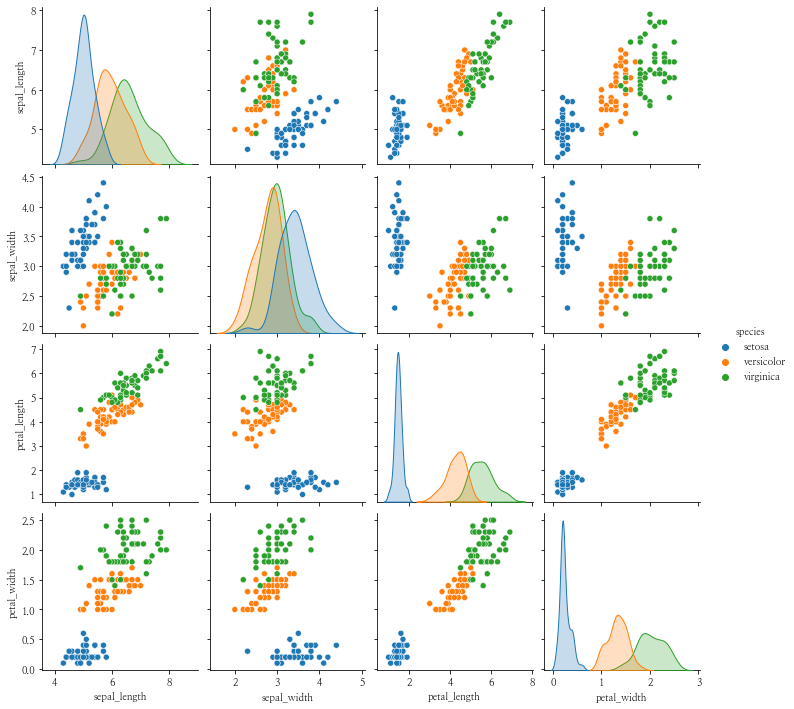

In [58]:
import matplotlib.pyplot as plt

sns.pairplot(iris1, kind="scatter", hue="species")
plt.show()

### spark로 상관관계 (correlation)

##### 데이터
웹사이트에 있는 데이터 불러오기

In [59]:
import pandas as pd

file_name = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
iris = pd.read_csv(file_name, names=["sepal_length","sepal_width","petal_length", "petal_width","species"])

In [60]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#### 박스 (boxplot)
IQR (Interquartile Rnage) 결측값이 있는지  확인, 동그라미는 outlier

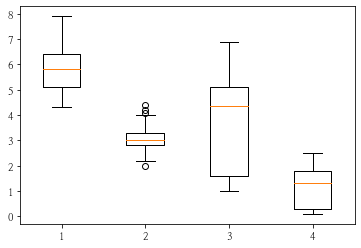

In [61]:
import matplotlib.pyplot as plt

iris4 = [ iris.sepal_length, iris.sepal_width, iris.petal_length, iris.petal_width ]
plt.boxplot(iris4)
plt.show()

#### DataFrame 생성
pandas -> DataFrame

In [62]:
irisDf = spark.createDataFrame(iris)
irisDf.printSchema()

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- species: string (nullable = true)



#### 상관관계
변수가 4개면 spark라면 features를 만들어야함 또한 각각을 벡터로 만들어야함

In [63]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
                                       outputCol="features")
df_vector = assembler.transform(irisDf).select("features")

상관관계 구하기

In [64]:
from pyspark.ml.stat import Correlation

# get correlation matrix
matrix = Correlation.corr(df_vector, "features")

#### 상관관계표

In [65]:
matrix.collect()

[Row(pearson(features)=DenseMatrix(4, 4, [1.0, -0.1094, 0.8718, 0.818, -0.1094, 1.0, -0.4205, -0.3565, 0.8718, -0.4205, 1.0, 0.9628, 0.818, -0.3565, 0.9628, 1.0], False))]

In [66]:
matrix.collect()[0][0].toArray()

array([[ 1.        , -0.10936925,  0.87175416,  0.81795363],
       [-0.10936925,  1.        , -0.4205161 , -0.35654409],
       [ 0.87175416, -0.4205161 ,  1.        ,  0.9627571 ],
       [ 0.81795363, -0.35654409,  0.9627571 ,  1.        ]])